In [3]:
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

DATE_STR = dt.datetime.now().strftime("%Y-%m-%d")
APP_NAME = "recomart"

BASE_RAW = "storage\\raw"
BASE_PREPARED = "prepared"
BASE_LOGS = "logs"
BASE_PLOTS = "plots"
REPORT_PATH = "Prepared_Data_Quality_Report.pdf"

LOG_FILE_PATH = os.path.join(BASE_LOGS, f"{APP_NAME}_{DATE_STR}.log")

def log_step(task, status, message):
    timestamp = dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    os.makedirs(BASE_LOGS, exist_ok=True)
    entry = f"[{timestamp}] [{task}] [{status}] {message}\n"
    with open(LOG_FILE_PATH, "a", encoding="utf-8") as f:
        f.write(entry)
    print(entry.strip())

for folder in [BASE_LOGS, BASE_PLOTS]:
    os.makedirs(folder, exist_ok=True)

[2026-01-27 20:39:20] [TASK_5] [FETCH] Reloading raw data for independent Task 5 session.
[2026-01-27 20:39:24] [TASK_5] [START] Performing data cleaning, preprocessing, and exploratory analysis phase.
[2026-01-27 20:39:24] [TASK_5] [PROCESS] Combining user files and stripping out duplicate entries.
[2026-01-27 20:39:25] [TASK_5] [CLEAN] Checking for impossible age values and setting them to a neutral state.
[2026-01-27 20:39:26] [TASK_5] [SAVE] I have archived the cleaned user profiles in the prepared directory.
[2026-01-27 20:39:26] [TASK_5] [PROCESS] De-duplicating the product catalog to ensure unique item IDs.
[2026-01-27 20:39:26] [TASK_5] [SAVE] The refined product list has been successfully exported.
[2026-01-27 20:39:26] [TASK_5] [EDA] Starting the visualization process.
[2026-01-27 20:39:27] [TASK_5] [PLOT] Sketching out the user age distribution histogram.


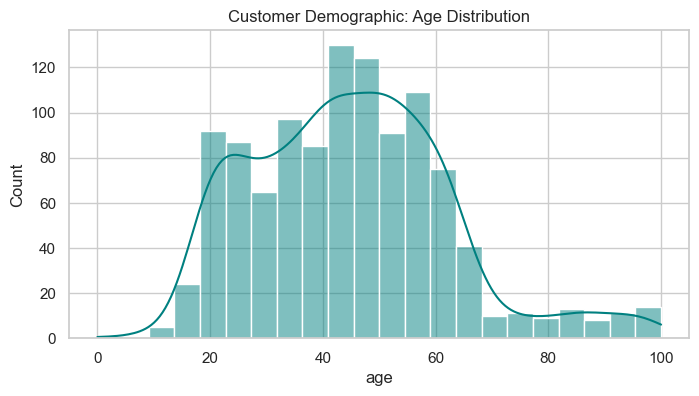

[2026-01-27 20:39:33] [TASK_5] [PLOT] Mapping the price points across our product catalog.


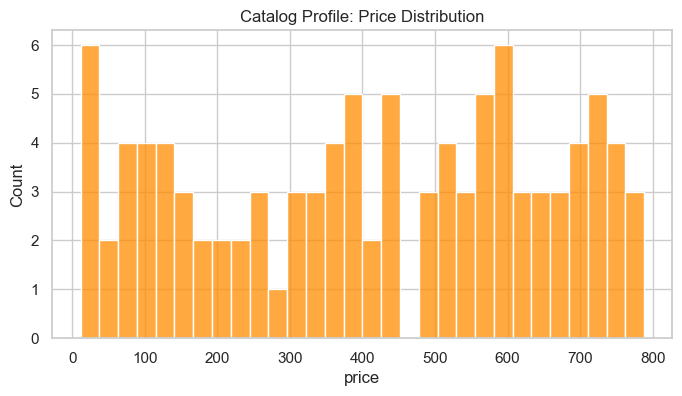

[2026-01-27 20:39:36] [TASK_5] [PLOT] Calculating correlations between transaction metrics for the heatmap.


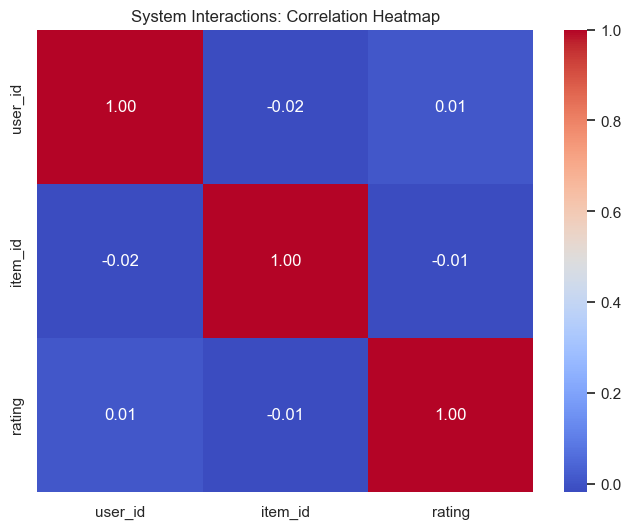

[2026-01-27 20:39:39] [TASK_5] [SUCCESS] EDA saved three plots in the plots folder.


In [4]:

PATHS = {
    "users": os.path.join(BASE_RAW, "users", DATE_STR),
    "products": os.path.join(BASE_RAW, "products", DATE_STR),
    "transactions": os.path.join(BASE_RAW, "transactions", DATE_STR)
}

try:
    log_step("TASK_5", "FETCH", "Reloading raw data for independent Task 5 session.")
    users_raw = pd.read_parquet(os.path.join(PATHS["users"], "users_merged.parquet"))

    prods_raw = pd.read_parquet(os.path.join(PATHS["products"], "products.parquet"))

    txns_raw = pd.read_parquet(os.path.join(PATHS["transactions"], "transactions_merged.parquet"))

    
    OUT_PATHS = {
        "users": os.path.join(BASE_PREPARED, "users", DATE_STR),
        "products": os.path.join(BASE_PREPARED, "products", DATE_STR),
        "transactions": os.path.join(BASE_PREPARED, "transactions", DATE_STR)
    }
    for p in OUT_PATHS.values(): os.makedirs(p, exist_ok=True)

    log_step("TASK_5", "START", "Performing data cleaning, preprocessing, and exploratory analysis phase.")

    
    log_step("TASK_5", "PROCESS", "Combining user files and stripping out duplicate entries.")
    u_clean = users_raw.drop_duplicates()
    
    if 'age' in u_clean.columns:
        log_step("TASK_5", "CLEAN", "Checking for impossible age values and setting them to a neutral state.")
        u_clean['age'] = pd.to_numeric(u_clean['age'], errors='coerce')
        u_clean.loc[(u_clean['age'] < 0) | (u_clean['age'] > 110), 'age'] = np.nan
    
    u_clean.to_csv(os.path.join(OUT_PATHS["users"], "users_final.csv"), index=False)
    log_step("TASK_5", "SAVE", "I have archived the cleaned user profiles in the prepared directory.")

    
    log_step("TASK_5", "PROCESS", "De-duplicating the product catalog to ensure unique item IDs.")
    p_clean = prods_raw.drop_duplicates(subset=['item_id'])
    p_clean.to_csv(os.path.join(OUT_PATHS["products"], "products_final.csv"), index=False)
    
    log_step("TASK_5", "SAVE", "The refined product list has been successfully exported.")
    
    
    txns_raw.to_csv(os.path.join(OUT_PATHS["transactions"], "transactions_final.csv"), index=False)


    
    log_step("TASK_5", "EDA", "Starting the visualization process.")
    sns.set_theme(style="whitegrid")

    
    if 'age' in u_clean.columns:
        log_step("TASK_5", "PLOT", "Sketching out the user age distribution histogram.")
        plt.figure(figsize=(8,4))
        sns.histplot(u_clean['age'].dropna(), kde=True, color='teal')
        plt.title("Customer Demographic: Age Distribution")
        # SAVE FIRST, THEN SHOW
        plt.savefig(os.path.join(BASE_PLOTS, "eda_user_age.png"))
        plt.show() 
        plt.close()

   
    if 'price' in p_clean.columns:
        log_step("TASK_5", "PLOT", "Mapping the price points across our product catalog.")
        plt.figure(figsize=(8,4))
        sns.histplot(p_clean['price'].dropna(), bins=30, color='darkorange')
        plt.title("Catalog Profile: Price Distribution")
        plt.savefig(os.path.join(BASE_PLOTS, "eda_product_prices.png"))
        plt.show()
        plt.close()

    
    log_step("TASK_5", "PLOT", "Calculating correlations between transaction metrics for the heatmap.")
    plt.figure(figsize=(8,6))
    corr = txns_raw.select_dtypes(include=[np.number]).corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("System Interactions: Correlation Heatmap")
    plt.savefig(os.path.join(BASE_PLOTS, "eda_transaction_heatmap.png"))
    plt.show()
    plt.close()

    log_step("TASK_5", "SUCCESS", f"EDA saved three plots in the {BASE_PLOTS} folder.")

except Exception as e:
    log_step("TASK_5", "ERROR", f"The preparation process hit a snag: {str(e)}")